In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import contractions
import re
import seaborn as sns
import spacy

### Load the training data

In [5]:
PROJECT_ROOT = Path() / "../"
DATASET_PATH = PROJECT_ROOT / "raw/competitions/jigsaw-toxic-comment-classification-challenge"
TRAIN_PATH = DATASET_PATH / "csv" / "train.csv"
TEST_PATH = DATASET_PATH / "csv" / "test.csv"
TEST_LABELS = DATASET_PATH / "csv" / "test_labels.csv"

In [6]:
df = pd.read_csv(TRAIN_PATH)

### Take a quick look at the dataset

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


We have total of 159,571 records. Each record has:
- A comment text which we will process to get our features for the data
- Six toxicity labels : toxic, severe_toxic, obscene, threat, insult, identity_hate

Our objective is to label / classify the toxicity of a comment for each of the toxicity types. Clearly, it is a multi-label classification problem.

### Understanding the data

In [6]:
# comment length
comment_len = df['comment_text'].str.len()
comment_len.rename('comment_length', inplace=True)
comment_len.describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64

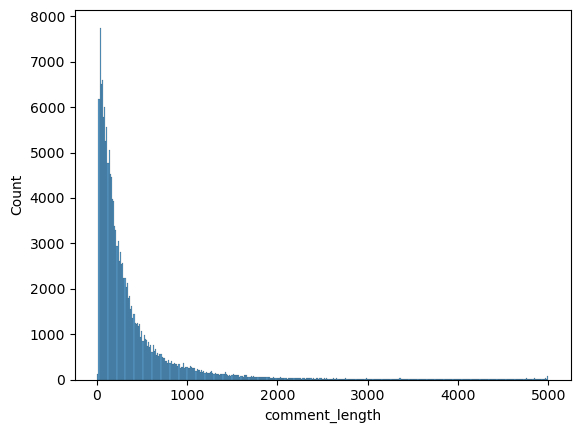

In [7]:
sns.histplot(comment_len)
plt.show()

In [358]:
toxicity_types = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [9]:
labels = df[toxicity_types]

In [10]:
# count of toxic comments for each type
labels.sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

We can see clearly that we have a class imbalanced dataset. Only about 10% of the comments are toxic, and the sample counts of other toxicity types are even lesser.

For simplicity, let’s start by predicting just the toxic label (binary classification: toxic or not). We can extend this to multi-label later.

In [11]:
# toxic comments - rows where any of the label is 1
toxic_comments = df.loc[(df[toxicity_types] == 1).any(axis=1)]

In [12]:
toxic_comments

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


In [694]:
sample_comment = toxic_comments.loc[12, 'comment_text']
sample_comment

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

### Preprocessing text data

#### Text processing steps:

1. lower case
2. remove urls, emails, usernames
3. remove digits, dates, words containing digits
4. expand word contractions
5. remove line breaks, extra spaces
5. remove punctuation
6. remove stop words
7. lemmatize

In [1]:
# regex patterns

email_pattern = re.compile(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}")
url_pattern = re.compile(r"http[s]?://\S+|www\.\S+")
username_pattern = re.compile(r"@[\w\d_-]+")
extra_spaces = re.compile(r"\s+")
words_with_digits = re.compile(r"[a-zA-Z]+\d+\w*|[0-9]+[a-z]")   # matches words containing digits
punct_pattern = re.compile(r"[!\"#$%&\'()*+,\-./:;<=>?@[\\\]^_`{|}~]")

NameError: name 're' is not defined

In [645]:
def process_text(comment, pipeline, keep_stop_words=False, stop_words=None, 
                 keep_punct=False, punct=None):
    
    # lower case
    comment = comment.lower()
    
    # remove emails, urls, usernames, 
    comment = email_pattern.sub('', comment)
    comment = url_pattern.sub('', comment)
    comment = username_pattern.sub('', comment)
    
    # remove numbers, dates, and words containing digits
    comment = digits_pattern.sub('', comment)
    
    # expand word contractions (e.g "you'r" to "you are")
    comment = contractions.fix(comment)
    
    # remove line breaks / extra spaces
    comment = extra_spaces.sub(' ', comment).strip()
    
    # tokenize text
    doc = pipeline(comment)
        
    # remove punctuation
    if not keep_punct:
        # raise exception / warning if `punc` is not None
        # code here
        doc = [token for token in doc if not token.is_punct]
    # For toxicity detection, keeping some punctuation (e.g., “!!!”) might hint at tone
    elif punct is not None:
        doc = [token for token in doc if not token.is_punct or token.text in punct]
    
    # remove stop words
    if not keep_stop_words:
        # raise exception / warning if `stop_words` is not None
        # code here
        en_stop_words = spacy.lang.en.stop_words.STOP_WORDS.copy()
        doc = [token for token in doc if token.text not in en_stop_words]
    # For toxicity detection, some stop words (e.g., “you”) might matter.
    elif stop_words is not None:
        en_stop_words = spacy.lang.en.stop_words.STOP_WORDS.copy()
        for word in stop_words:
            en_stop_words.discard(word)
        doc = [token for token in doc if token.text not in en_stop_words]
        
        
    # lemmatize
    tokens = [token.lemma_ for token in doc]
    
    return " ".join(tokens)

In [571]:
sample_text = df.loc[159546, 'comment_text']
sample_text

'"\n\nHey listen don\'t you ever!!!! Delete my edits ever again I\'m annoyed because the WWE 2K15 a few of the roster have been confirmed and your stupid ass deletes what I write. just stop!!!! Please STOP!!!! You don\'t work 2k or WWE games so stop deleting other peoples shit if I get it wrong or others get it wrong let them they will get the hang of it eventually but don\'t stick your most ass in their and I\'m gonna delete the ""please do not insert the roster"" shit how do you not have it if has been confirmed!!!!! God your stupid."'

In [744]:
nlp = spacy.load('en_core_web_sm')
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [631]:
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

In [633]:
process_text(sample_text, nlp, keep_stop_words=True, stop_words=['you'])

'hey listen you delete edit annoy wwe roster confirm stupid ass delete write stop stop you work wwe game stop delete people shit wrong wrong let hang eventually stick ass go delete insert roster shit you confirm god stupid'

In [634]:
# process comments
    
df['processed_comment'] = df['comment_text'].apply(
    lambda x : process_text(x, nlp, keep_stop_words=True, stop_words=['you'])
)

In [637]:
df['processed_comment'].str.len().describe()

count    159571.000000
mean        215.965639
std         346.216317
min           0.000000
25%          50.000000
50%         109.000000
75%         233.000000
max        5665.000000
Name: processed_comment, dtype: float64

In [638]:
# drop rows where `processed_comment` is empty string

drop_index = df[df['processed_comment'].str.len() == 0].index
processed_df = df.drop(drop_index)

In [369]:
# extra - padding and truncate tokens list, if needed

def vectorize(text, max_len=100):
    tokens = text.split()
    tokens = (
        tokens[:max_len] + ["<PAD>"] * (max_len - len(tokens))
        if max_len > len(tokens)
        else tokens[:max_len]
    )
    return tokens

In [701]:
processed_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edit username hardcore metallica f...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww match background colour seemingly stuck ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man try edit war guy constantly remove rel...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,real suggestion improvement wonder section sta...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir hero chance you remember page


### Feature extraction

#### Initialize TF-IDF Vectorizer

In [817]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(lowercase=False, max_features=5000)

X = tfidf_vectorizer.fit_transform(processed_df['processed_comment']).toarray()
y = processed_df['toxic'].values

In [818]:
print(X.shape, y.shape)

(159431, 5000) (159431,)


### Model selection and training

Split the data into training and validation sets to evaluate the model.

In [820]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, y_train.shape)

(119573, 5000) (119573,)


Let’s use Logistic Regression, a solid baseline for text classification.

In [821]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
# class_weight='balanced' handles the imbalance in toxic vs non-toxic

logistic_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

### Model Evaluation

\
We will focus on the F1-score for 'toxic' samples due to class imbalance in the dataset

In [822]:
y_pred = logistic_reg.predict(X_val)

In [73]:
from sklearn.metrics import classification_report

In [823]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     36026
           1       0.60      0.87      0.71      3832

    accuracy                           0.93     39858
   macro avg       0.79      0.91      0.84     39858
weighted avg       0.95      0.93      0.94     39858



Let's try some other models as well

In [727]:
def train_eval_model(model, X_train, y_train, X_test, y_test):
    # train model
    model.fit(X_train, y_train)
    
    # predict
    y_pred = model.predict(X_test)
    
    # evaluate
    return classification_report(y_test, y_pred)

Naive Bayes classifier

In [825]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_clf = MultinomialNB(alpha=0.1) 

print(train_eval_model(naive_bayes_clf, X_train, y_train, X_val, y_val))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     36026
           1       0.92      0.54      0.68      3832

    accuracy                           0.95     39858
   macro avg       0.94      0.77      0.83     39858
weighted avg       0.95      0.95      0.95     39858



Let's also try Random Forest classifier

In [826]:
from sklearn.ensemble import RandomForestClassifier

rand_forest_clf = RandomForestClassifier(n_estimators=50, class_weight='balanced', 
                                         random_state=42, n_jobs=-1)

rand_forest_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=-1,
                       random_state=42)

In [827]:
y_pred = rand_forest_clf.predict(X_val)

In [828]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     36026
           1       0.84      0.61      0.71      3832

    accuracy                           0.95     39858
   macro avg       0.90      0.80      0.84     39858
weighted avg       0.95      0.95      0.95     39858



Logistic Regression give us a good baseline for text classification. We see the Naive Bayes and Random Forest also give similar performance.

### Try using pretrained word embeddings
\
Let's use word embeddings to represent text, like GloVe which can capture semantic meaning and to some extent context of words.

In [771]:
# load and prepare glove embeddings

GLOVE_PATH = PROJECT_ROOT / "data/external/glove6B/glove.6B.100d.txt"
GLOVE_PATH.mkdir(parents=True, exists_ok=True)

def load_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [772]:
glove_embeddings = load_embeddings(GLOVE_PATH)

In [790]:
# transform text to word embeddings

def text_to_embedding(text, embeddings, embedding_dim=100):
    """
    Average the embeddings of all words in `text`. 
    If a word isn’t in GloVe, use a zero vector or skip it.
    """
    tokens = text.split()
    word_vectors = [embeddings[word] for word in tokens if word in embeddings]
    if not word_vectors:
        return np.zeros(embedding_dim)
    return np.mean(word_vectors, axis=0)

In [792]:
X_embeddings = np.array(
    [text_to_embedding(text, glove_embeddings) for text in processed_df['processed_comment']]
)
y = processed_df['toxic'].values

In [793]:
print(X_embeddings.shape, y.shape)

(159431, 100) (159431,)


In [794]:
# split data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X_embeddings, y, test_size=0.15, random_state=42)
print(X_train.shape, y_train.shape)

(135516, 100) (135516,)


In [797]:
# train models

classification_scores = train_eval_model(
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    X_train, y_train, X_val, y_val
)
print(classification_scores)

              precision    recall  f1-score   support

           0       0.98      0.88      0.92     21639
           1       0.41      0.83      0.55      2276

    accuracy                           0.87     23915
   macro avg       0.69      0.85      0.74     23915
weighted avg       0.93      0.87      0.89     23915



In [ ]:
# Linear SVC (might take forever to run on CPU, or crash jupyter notebook)

# svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)

# classification_scores = train_eval_model(svm_model, X_train, y_train, X_val, y_val)
# print(classification_scores)

In [800]:
rand_forest_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', 
                                         random_state=42, n_jobs=-1)

classification_scores = train_eval_model(rand_forest_clf, X_train, y_train, X_val, y_val)
print(classification_scores)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     21639
           1       0.85      0.36      0.51      2276

    accuracy                           0.93     23915
   macro avg       0.89      0.68      0.74     23915
weighted avg       0.93      0.93      0.92     23915



Clearly, word embeddings performed worse than TF-IDF vectorizer. This might be because:
1. Our data contains a lot of out-of-vocabulary words (slurs and slangs), for which GloVe might not have vector embeddings
2. Averaging word embeddings dilutes the contribution of individual words, especially rare but highly indicative ones (e.g., slurs)

In [ ]:
# capitalized words carry weight - maybe but might not have much effect
# keep stopwords like 'you' - done
# @user -> remove usernames - done
# u, r, ur -> you, are, your - slang conversion done
# !!! -> keep punctuation like this - partially done, think about '!!!' instead of '! ! !'

# create spacy pipeline for all steps
# try with stop_words=['you'] and punc=['!']